In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
x_train = pd.read_csv("MADBase/x_train.csv", header=None)
y_train = pd.read_csv("MADBase/y_train.csv", header=None, names=['label'])
x_test = pd.read_csv("MADBase/x_test.csv", header=None)
y_test = pd.read_csv("MADBase/y_test.csv", header=None, names=['label'])

In [4]:
print("x_train shape", x_train.shape)
print("y_train shape", y_train.shape)
print("x_test shape", x_test.shape)
print("y_test shape", y_test.shape)

x_train shape (60000, 784)
y_train shape (60000, 1)
x_test shape (10000, 784)
y_test shape (10000, 1)


In [5]:
x_train.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
y_train.head()

,label
0,0
1,1
2,2
3,3
4,4


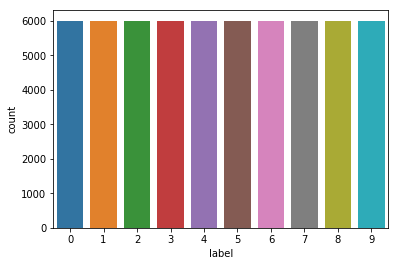

In [7]:
sns.countplot(y_train['label'])

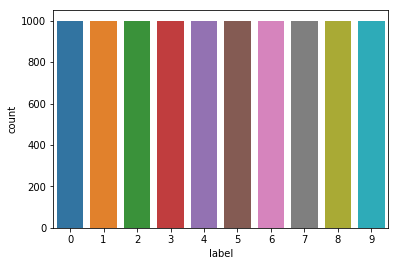

In [8]:
sns.countplot(y_test['label'])

### Convert and rotate vectors

In [9]:
def rot_digit(digit):
    return np.fliplr(np.rot90(digit, axes=(1,0)))

In [10]:
x_train = x_train.astype('float32').values
y_train = y_train.astype('float32').values
x_test  = x_test.astype('float32').values
y_test  = y_test.astype('float32').values

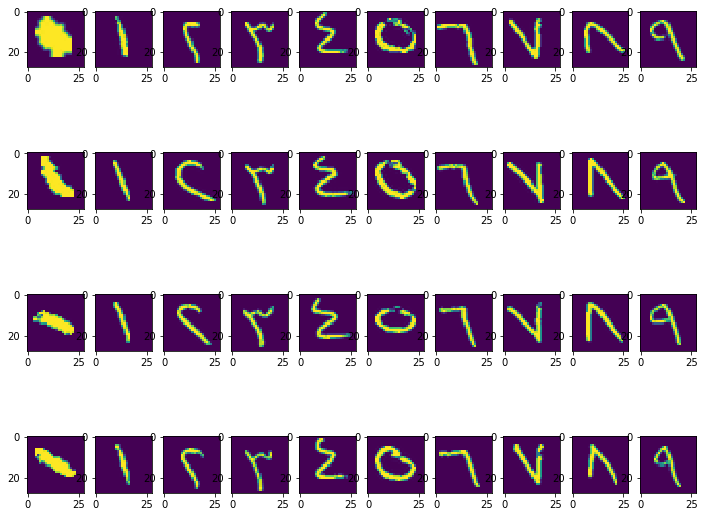

In [11]:
plt.figure(figsize=(12,10))
x, y = 10, 4
for i in range(40):  
    plt.subplot(y, x, i+1)
    plt.imshow(rot_digit(x_train[i].reshape((28,28))), interpolation='nearest')
plt.show()

### Normalize

In [12]:
x_train = x_train/255.0
x_test = x_test/255.0

In [13]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 784)
60000 train samples
10000 test samples


### Reshape for keras

In [14]:
X_train = x_train.reshape(x_train.shape[0], 28, 28,1)
X_test = x_test.reshape(x_test.shape[0], 28, 28,1)

### Keras

In [15]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
batch_size = 32
num_classes = 10
epochs = 20
input_shape = (28, 28, 1)

Using TensorFlow backend.


### Split Training data

In [16]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=42)

### The CNN model

In [17]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='lecun_normal',input_shape=input_shape))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.20))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='lecun_normal'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='lecun_normal'))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu',padding='same',kernel_initializer='lecun_normal'))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu',padding='same',kernel_initializer='lecun_normal'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [18]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

### Data augmentation

In [19]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15, # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 64)          36928     
__________

## تأكد أن تنفذ واحد من الخليتين التاليتين وليس كلاهما

### Train without data augmentation

In [ ]:
history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs, verbose=1, validation_data=(X_val, Y_val))

### Train with data augmentation

In [21]:
datagen.fit(X_train)
history_aug = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                                  epochs = epochs, validation_data = (X_val,Y_val),
                                  verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size,
                                  callbacks=[learning_rate_reduction],)

Epoch 1/20
1687/1687 [==============================] - 17s 10ms/step - loss: 0.2062 - acc: 0.9360 - val_loss: 0.0351 - val_acc: 0.9913
Epoch 2/20
1687/1687 [==============================] - 15s 9ms/step - loss: 0.0685 - acc: 0.9803 - val_loss: 0.0308 - val_acc: 0.9915
Epoch 3/20
1687/1687 [==============================] - 15s 9ms/step - loss: 0.0547 - acc: 0.9842 - val_loss: 0.0174 - val_acc: 0.9945
Epoch 4/20
1687/1687 [==============================] - 15s 9ms/step - loss: 0.0490 - acc: 0.9854 - val_loss: 0.0241 - val_acc: 0.9930
Epoch 5/20
1687/1687 [==============================] - 15s 9ms/step - loss: 0.0445 - acc: 0.9871 - val_loss: 0.0191 - val_acc: 0.9953
Epoch 6/20
1687/1687 [==============================] - 15s 9ms/step - loss: 0.0407 - acc: 0.9886 - val_loss: 0.0224 - val_acc: 0.9940
Epoch 7/20
1687/1687 [==============================] - 15s 9ms/step - loss: 0.0359 - acc: 0.9899 - val_loss: 0.0144 - val_acc: 0.9958
Epoch 8/20
1687/1687 [==============================] 

### Validation evaluation أداء النموذج على الفاليديشن ست

In [22]:
final_loss, final_acc = model.evaluate(X_val, Y_val, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

Final loss: 0.011231, final accuracy: 0.997500


### Test evaluation أداء النموذج على التست ست

In [23]:
final_loss, final_acc = model.evaluate(X_test, y_test, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

Final loss: 0.023157, final accuracy: 0.994000


In [ ]:
#Note, this code is taken straight from the SKLEARN website, an nice way of viewing confusion matrix.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


### Validation Confusion Matrix

In [ ]:
# Predict the values from the validation dataset
Y_pred_val = model.predict(X_val)

# Convert predictions classes to one hot vectors 
Y_pred_val_classes = np.argmax(Y_pred_val, axis = 1) 

# Convert validation observations to one hot vectors
Y_true_val = np.argmax(Y_val, axis = 1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true_val, Y_pred_val_classes) 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

### Testing Confusion Matrix

In [ ]:
# Predict the values from the validation dataset
Y_pred_test = model.predict(X_test)

# Convert predictions classes to one hot vectors 
Y_pred_test_classes = np.argmax(Y_pred_test, axis = 1) 

# Convert validation observations to one hot vectors
Y_true_test = np.argmax(y_test, axis = 1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true_test, Y_pred_test_classes) 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

### Training History

In [ ]:
# history_aug اذا كنت مرنت النموذج على الأوقمنتد داتا، استخدم السطر الأول 
h = history_aug
#h = history

print(h.history.keys())
accuracy = h.history['acc']
val_accuracy = h.history['val_acc']
loss = h.history['loss']
val_loss = h.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


### Errors from validations

In [ ]:
# Errors are difference between predicted labels and true labels
errors = (Y_pred_val_classes - Y_true_val != 0)

Y_pred_classes_errors = Y_pred_val_classes[errors]
Y_pred_errors = Y_pred_val[errors]
Y_true_errors = Y_true_val[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 4
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow(rot_digit(img_errors[error].reshape((28,28))))
            ax[row,col].set_title("{}:{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-8:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)


In [ ]:
most_important_errors = sorted_dela_errors[-16:-8]
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [ ]:
most_important_errors = sorted_dela_errors[-24:-16]
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [ ]:
(len(Y_true_val) - len(sorted_dela_errors)) / len(Y_true_val)

### Errors from validations

In [ ]:
# Errors are difference between predicted labels and true labels
errors = (Y_pred_test_classes - Y_true_test != 0)

Y_pred_classes_errors = Y_pred_test_classes[errors]
Y_pred_errors = Y_pred_test[errors]
Y_true_errors = Y_true_test[errors]
X_test_errors = X_test[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 4
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow(rot_digit(img_errors[error].reshape((28,28))))
            ax[row,col].set_title("{}:{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-8:]

# Show the top 6 errors
display_errors(most_important_errors, X_test_errors, Y_pred_classes_errors, Y_true_errors)

In [ ]:
most_important_errors = sorted_dela_errors[-16:-8]
display_errors(most_important_errors, X_test_errors, Y_pred_classes_errors, Y_true_errors)

In [ ]:
most_important_errors = sorted_dela_errors[-24:-16]
display_errors(most_important_errors, X_test_errors, Y_pred_classes_errors, Y_true_errors)

In [ ]:
(len(Y_true_test) - len(sorted_dela_errors)) / len(Y_true_test)